In [2]:
import warnings
import torch
import numpy as np

warnings.filterwarnings("ignore", category=FutureWarning)

# Load tensor
spikes_tensor = torch.load("C:/Users/dines/Capstone Project/tensors/spike_data_tensor.pt")
labels_tensor = torch.load("C:/Users/dines/Capstone Project/tensors/labels_tensor.pt")

# Ensure labels_tensor is a tensor
if isinstance(labels_tensor, list):
    labels_tensor = torch.tensor(labels_tensor)

label_distribution = torch.bincount(labels_tensor)
print(f'Original Labels distribution: {label_distribution}')

Original Labels distribution: tensor([1294,   95, 1046,   53,   40])


In [3]:
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import tonic

class CCMKDataset(Dataset):
    def __init__(self, spikes_tensor, labels_tensor, nchannels=None, target_label=2, seed=None, device=None):
        # Random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        # Move tensors to the specified device
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.spikes_tensor = spikes_tensor.to(device)
        self.labels_tensor = labels_tensor.to(device)

        if nchannels is not None:
            self.spikes_tensor = self.spikes_tensor[:, nchannels, :]
        
        # Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]
        
        # Convert the target label (2) to 1
        self.labels_tensor[self.labels_tensor == target_label] = 1
        
        # Downsampling: Match the number of label 0 samples to the number of label 1 samples
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]
        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False), device=self.device)
        selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False), device=self.device)

        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int())}")

    def __len__(self):
        return len(self.labels_tensor)
    
    def __getitem__(self, idx):
        spike_data = self.spikes_tensor[idx]
        label = self.labels_tensor[idx]
        return spike_data, label

### Dataset and DataLoader Configuration

In [4]:
dataset = CCMKDataset(spikes_tensor, labels_tensor, nchannels=list(range(16)), seed=42)

# Balance the dataset by selecting equal samples from both classes
label_0_indices = torch.where(dataset.labels_tensor == 0)[0]
label_1_indices = torch.where(dataset.labels_tensor == 1)[0]

dataset_0 = torch.utils.data.Subset(dataset, label_0_indices)
dataset_1 = torch.utils.data.Subset(dataset, label_1_indices)

# Split size
train_size_0 = int(0.8 * len(dataset_0))
val_size_0 = int(0.1 * len(dataset_0))
test_size_0 = len(dataset_0) - train_size_0 - val_size_0

train_size_1 = int(0.8 * len(dataset_1))
val_size_1 = int(0.1 * len(dataset_1))
test_size_1 = len(dataset_1) - train_size_1 - val_size_1

# Split the dataset
train_dataset_0, val_dataset_0, test_dataset_0 = random_split(dataset_0, [train_size_0, val_size_0, test_size_0], generator=torch.Generator().manual_seed(42))
train_dataset_1, val_dataset_1, test_dataset_1 = random_split(dataset_1, [train_size_1, val_size_1, test_size_1], generator=torch.Generator().manual_seed(42))

# Combine splits from both classes
train_dataset = torch.utils.data.ConcatDataset([train_dataset_0, train_dataset_1])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_0, val_dataset_1])
test_dataset = torch.utils.data.ConcatDataset([test_dataset_0, test_dataset_1])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Filtered Labels distribution after processing: tensor([1046, 1046])


In [5]:
# Adapted from Esther's snn.ipynb notebook

# Check the length of the dataset
print(f"Dataset length: {len(dataset)}")

# Get and print the shape of the first sample in the dataset
first_spikes, first_label = dataset[0]
print(f"Shape of the first spikes tensor: {first_spikes.shape}")
print(f"Label of the first sample: {first_label}")

# Check batch information in the dataloader
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f" - Inputs shape: {inputs.shape}")  # Batch size x Number of channels x Number of time steps
    print(f" - Targets shape: {targets.shape}")
    break  # Only view the first batch

# Get the distribution of labels
labels = torch.cat([batch[1] for batch in train_loader])
print(f'Labels distribution: {torch.bincount(labels.int())}')

Dataset length: 2092
Shape of the first spikes tensor: torch.Size([16, 101])
Label of the first sample: 0
Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Targets shape: torch.Size([32])
Labels distribution: tensor([836, 836])


In [6]:
# Check the shape of tensors in a DataLoader
def check_dataloader_shapes(dataloader, loader_name=""):
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        print(f"Loader: {loader_name}, Batch {batch_idx + 1}:")
        print(f" - Inputs shape: {inputs.shape}")  
        print(f" - Labels shape: {labels.shape}")  
        break 

check_dataloader_shapes(train_loader, "Train Loader")
check_dataloader_shapes(val_loader, "Validation Loader")
check_dataloader_shapes(test_loader, "Test Loader")


Loader: Train Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])
Loader: Validation Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])
Loader: Test Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])


### Network Initialization

In [7]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking

net = SynNet(
    n_channels=16,                        
    n_classes=2,                           
    size_hidden_layers=[24, 24, 24],        
    time_constants_per_layer=[2, 4, 8],        
)

print(net)

c:\Users\dines\miniconda3\envs\capstone\lib\site-packages\rockpool\nn\networks\__init__.py:15: UserWarning: This module needs to be ported to teh v2 API.
  warnings.warn(f"{err}")
c:\Users\dines\miniconda3\envs\capstone\lib\site-packages\rockpool\nn\networks\__init__.py:20: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")


SynNet  with shape (16, 2) {
    TorchSequential 'seq' with shape (16, 2) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 2)
        LIFTorch '10_LIFTorch' with shape (2, 2)
    }
}


### Train & Validation

  2%|▏         | 1/50 [00:24<20:07, 24.64s/it]

Epoch 1/50, Training Loss: 0.6727785749255486, Validation Loss: 0.6476575051035199


  4%|▍         | 2/50 [00:48<19:34, 24.47s/it]

Epoch 2/50, Training Loss: 0.6545404623139579, Validation Loss: 0.5114605895110539


  6%|▌         | 3/50 [01:12<18:48, 24.00s/it]

Epoch 3/50, Training Loss: 0.600209725915261, Validation Loss: 0.5599442848137447


  8%|▊         | 4/50 [01:34<17:57, 23.42s/it]

Epoch 4/50, Training Loss: 0.6145219797233366, Validation Loss: 0.6502024573939187


 10%|█         | 5/50 [01:57<17:21, 23.13s/it]

Epoch 5/50, Training Loss: 0.5765360076472444, Validation Loss: 0.6013697854110173


 12%|█▏        | 6/50 [02:21<17:10, 23.42s/it]

Epoch 6/50, Training Loss: 0.5714730648499615, Validation Loss: 0.49495040093149456


 14%|█▍        | 7/50 [02:45<16:55, 23.62s/it]

Epoch 7/50, Training Loss: 0.5461752088564746, Validation Loss: 0.5140544686998639


 16%|█▌        | 8/50 [03:09<16:38, 23.78s/it]

Epoch 8/50, Training Loss: 0.5685415402898248, Validation Loss: 0.6078044772148132


 18%|█▊        | 9/50 [03:32<16:03, 23.50s/it]

Epoch 9/50, Training Loss: 0.5595555485419508, Validation Loss: 0.5095902000154767


 20%|██        | 10/50 [03:55<15:27, 23.19s/it]

Epoch 10/50, Training Loss: 0.5576877509647945, Validation Loss: 0.548247333083834


 22%|██▏       | 11/50 [04:18<15:12, 23.39s/it]

Epoch 11/50, Training Loss: 0.5356280561887993, Validation Loss: 0.5059238459382739


 24%|██▍       | 12/50 [04:43<14:59, 23.68s/it]

Epoch 12/50, Training Loss: 0.5399431501919368, Validation Loss: 0.5397677421569824


 26%|██▌       | 13/50 [05:06<14:33, 23.60s/it]

Epoch 13/50, Training Loss: 0.5245438184378282, Validation Loss: 0.4997636675834656


 28%|██▊       | 14/50 [05:30<14:08, 23.56s/it]

Epoch 14/50, Training Loss: 0.5187529848431641, Validation Loss: 0.5325350931712559


 30%|███       | 15/50 [05:53<13:43, 23.53s/it]

Epoch 15/50, Training Loss: 0.5127612031855673, Validation Loss: 0.5186932470117297


 32%|███▏      | 16/50 [06:18<13:29, 23.80s/it]

Epoch 16/50, Training Loss: 0.49581361997802303, Validation Loss: 0.49003712620053974


 34%|███▍      | 17/50 [06:42<13:16, 24.14s/it]

Epoch 17/50, Training Loss: 0.4881715774536133, Validation Loss: 0.4848493593079703


 36%|███▌      | 18/50 [07:09<13:11, 24.73s/it]

Epoch 18/50, Training Loss: 0.47663936581251753, Validation Loss: 0.4560187544141497


 38%|███▊      | 19/50 [07:35<13:03, 25.27s/it]

Epoch 19/50, Training Loss: 0.47227818673511723, Validation Loss: 0.466917736189706


 40%|████      | 20/50 [08:01<12:42, 25.40s/it]

Epoch 20/50, Training Loss: 0.4647252323492518, Validation Loss: 0.4626279515879495


 42%|████▏     | 21/50 [08:26<12:15, 25.37s/it]

Epoch 21/50, Training Loss: 0.4725648479641609, Validation Loss: 0.4621789540563311


 44%|████▍     | 22/50 [08:52<11:56, 25.57s/it]

Epoch 22/50, Training Loss: 0.47647158436055453, Validation Loss: 0.4903116055897304


 46%|████▌     | 23/50 [09:17<11:26, 25.41s/it]

Epoch 23/50, Training Loss: 0.4709772551959416, Validation Loss: 0.46432386551584515


 48%|████▊     | 24/50 [09:42<10:58, 25.32s/it]

Epoch 24/50, Training Loss: 0.47063803785252123, Validation Loss: 0.4613810053893498


 50%|█████     | 25/50 [10:07<10:30, 25.23s/it]

Epoch 25/50, Training Loss: 0.47158992121804433, Validation Loss: 0.48619631784302847


 52%|█████▏    | 26/50 [10:33<10:07, 25.30s/it]

Epoch 26/50, Training Loss: 0.4665896549539746, Validation Loss: 0.4758463033608028


 54%|█████▍    | 27/50 [10:58<09:41, 25.29s/it]

Epoch 27/50, Training Loss: 0.4641949011469787, Validation Loss: 0.4686136543750763


 56%|█████▌    | 28/50 [11:24<09:17, 25.34s/it]

Epoch 28/50, Training Loss: 0.4637831854370405, Validation Loss: 0.45539528131484985


 58%|█████▊    | 29/50 [11:48<08:49, 25.23s/it]

Epoch 29/50, Training Loss: 0.46452765700952064, Validation Loss: 0.47477386253220694


 60%|██████    | 30/50 [12:14<08:24, 25.21s/it]

Epoch 30/50, Training Loss: 0.4483113502556423, Validation Loss: 0.4536993716444288


 62%|██████▏   | 31/50 [12:39<08:00, 25.31s/it]

Epoch 31/50, Training Loss: 0.45834814433781607, Validation Loss: 0.449684066431863


 64%|██████▍   | 32/50 [13:06<07:43, 25.74s/it]

Epoch 32/50, Training Loss: 0.46153345704078674, Validation Loss: 0.4579891732760838


 66%|██████▌   | 33/50 [13:31<07:14, 25.55s/it]

Epoch 33/50, Training Loss: 0.4581011112006205, Validation Loss: 0.45459734967776705


 68%|██████▊   | 34/50 [13:57<06:49, 25.60s/it]

Epoch 34/50, Training Loss: 0.45551862525490094, Validation Loss: 0.4707585573196411


 70%|███████   | 35/50 [14:23<06:25, 25.69s/it]

Epoch 35/50, Training Loss: 0.47149774375951514, Validation Loss: 0.4507565072604588


 72%|███████▏  | 36/50 [14:48<05:56, 25.48s/it]

Epoch 36/50, Training Loss: 0.44791284034836965, Validation Loss: 0.47030956404549734


 74%|███████▍  | 37/50 [15:13<05:30, 25.39s/it]

Epoch 37/50, Training Loss: 0.4467105449370618, Validation Loss: 0.4607575408049992


 76%|███████▌  | 38/50 [15:38<05:04, 25.41s/it]

Epoch 38/50, Training Loss: 0.4438315691812983, Validation Loss: 0.44798814824649263


 78%|███████▊  | 39/50 [16:04<04:41, 25.58s/it]

Epoch 39/50, Training Loss: 0.43921014216710935, Validation Loss: 0.456916732447488


 80%|████████  | 40/50 [16:30<04:15, 25.55s/it]

Epoch 40/50, Training Loss: 0.4426523233359715, Validation Loss: 0.43968304991722107


 82%|████████▏ | 41/50 [16:55<03:49, 25.54s/it]

Epoch 41/50, Training Loss: 0.4507060950657107, Validation Loss: 0.4703095853328705


 84%|████████▍ | 42/50 [17:21<03:24, 25.51s/it]

Epoch 42/50, Training Loss: 0.4465556948814752, Validation Loss: 0.46432386551584515


 86%|████████▌ | 43/50 [17:46<02:58, 25.49s/it]

Epoch 43/50, Training Loss: 0.4548697117364632, Validation Loss: 0.4486116256032671


 88%|████████▊ | 44/50 [18:09<02:27, 24.62s/it]

Epoch 44/50, Training Loss: 0.4605649889640088, Validation Loss: 0.4686136416026524


 90%|█████████ | 45/50 [18:31<02:00, 24.04s/it]

Epoch 45/50, Training Loss: 0.4504722784150322, Validation Loss: 0.46075754506247385


 92%|█████████▏| 46/50 [18:56<01:37, 24.29s/it]

Epoch 46/50, Training Loss: 0.4430443773854454, Validation Loss: 0.46629427586283


 94%|█████████▍| 47/50 [19:20<01:12, 24.18s/it]

Epoch 47/50, Training Loss: 0.44068588625709965, Validation Loss: 0.4530759198325021


 96%|█████████▌| 48/50 [19:45<00:48, 24.28s/it]

Epoch 48/50, Training Loss: 0.4419342611195906, Validation Loss: 0.445668773991721


 98%|█████████▊| 49/50 [20:10<00:24, 24.59s/it]

Epoch 49/50, Training Loss: 0.4373226818048729, Validation Loss: 0.4490606018475124


100%|██████████| 50/50 [20:35<00:00, 24.71s/it]

Epoch 50/50, Training Loss: 0.4350827864880832, Validation Loss: 0.44736468366214205


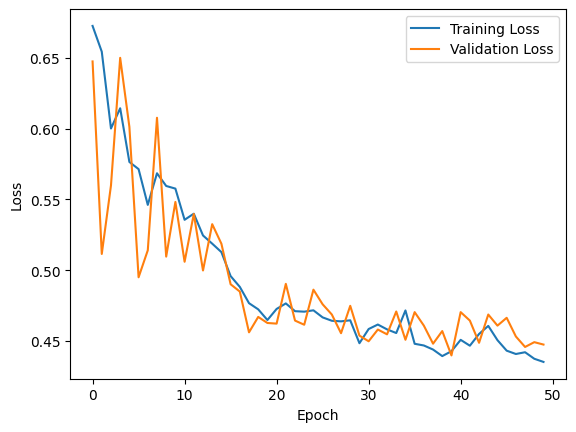

In [8]:
from torch.nn import CrossEntropyLoss
from tqdm import trange
from torch.optim import Adam
import matplotlib.pyplot as plt

# Hyperparameters
n_epochs = 50
learning_rate = 1e-3

optimizer = Adam(net.parameters().astorch(), lr=learning_rate)
loss_fun = CrossEntropyLoss()

# Store losses for plotting
train_losses = []
val_losses = []

# Training phase
for epoch in trange(n_epochs):
    net.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1)
        optimizer.zero_grad()
        outputs, _, _ = net(inputs)
        outputs = outputs[:, -1, :]
        loss = loss_fun(outputs, labels.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))

    
    # Validation phase
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.permute(0, 2, 1)
            outputs, _, _ = net(inputs)
            outputs = outputs[:, -1, :]
            loss = loss_fun(outputs, labels.long())
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))  

    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


Modified Training Loop to Track Predictions and Labels

In [ ]:
# Track all predictions and true labels
all_outputs = []
all_labels = []

# Validation phase
net.eval()
val_loss = 0
with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1)
        outputs, _, _ = net(inputs)
        outputs = outputs[:, -1, :]
        loss = loss_fun(outputs, labels.long())
        val_loss += loss.item()

        # Collect predictions and true labels
        all_outputs.append(outputs)
        all_labels.append(labels)

# Concatenate all predictions and labels
all_outputs = torch.cat(all_outputs).cpu()
all_labels = torch.cat(all_labels).cpu()

# Convert to numpy for metric calculations
y_pred_proba = all_outputs.numpy()
y_true = all_labels.numpy()

val_losses.append(val_loss / len(val_loader))

print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")


In [26]:
# Get the predicted class by taking the argmax (highest probability)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])  # Use probabilities for the positive class
print(f"ROC-AUC Score: {roc_auc:.2f}")

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],  # Adjust labels according to your classes
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()



NameError: name 'y_pred_proba' is not defined

In [ ]:
#generate classification report
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))